# Project Question

> Create a search function to search in a NAS space for the best performing **CNN architecture** on fashion-mnist.

Your task is to create a search function which searches for the model genome string that provides the best accuracy while using the least number of parameters.

Your program will return a model genome string (described below) which can be fed to a train function (provided below) to get the lowest parameter count and best accuracy after training.

**This is an open research problem**. You can use any method to search for the best genome and there might not be a perfect solution possible (prefect in the sense of maximum accuracy with minimum parameters). You will likely find tradeoffs between accuracy and number of parameters and you must balance such tradeoffs at your discretion.

> Aim for a search function that finds a genome with accuracy at least 75%.

You are encouraged to experiment with different techniques and apply your intuition to find a good search algorithm.

## CNN Architecture Constraints

Your search algorithm should search for models with the following basic structure.

Sequential model (no skip connections) having the following layers,
- Any number of normal(NC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A normal CNN layer has the following constraints,
    - `stride=1`
    - `padding=same`
    - `1 <= kernel size < 8`
    - Any of the following activation functions,
      - relu
      - sigmoid
      - tanh
      - swish
      - gelu
- **Exactly** 2 reduction(RC) CNN layers
  - `torch.nn.Conv2d` or `tf.keras.layers.Conv2D`
  - A reduction layer has the **same** constraints as the normal layer except the following,
    - `stride=2`
    - `padding=valid`
- **Exactly** the following structure as the **final layers**,
  - First, a Global Average Pooling 2D layer.
    - `torch.nn.AvgPool2d(kernel_size=layer_input_image_size)` or `tf.keras.layers.GlobalAveragePooling2D`
  - Then, a Fully Connected/Dense layer with 64 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(64)` or `tf.keras.layers.Dense(64)`
  - Then, a Fully Connected/Dense layer with 10 units (such that output is shape `(batch_size, 10)`)
    - This layer can have any of the allowed activations in NC layer but all final layers must use same activation.
    - `torch.nn.Linear(10)` or `tf.keras.layers.Dense(10)`


The normal(NC) and reduction(RC) layers can be in **any order** as long as the constraints above are maintained.

The final layers of you model should be exactly as mentioned in these constraints.

All of the above contraints **apply only to your final output**. During searching for the best architecture you can do whatever you want.

Once your algorithm finds the best architecture, it should represent the architecture as a genome string (explained below) which will be fed to the training function given below to get the final accuracy.

In [47]:
#@title Run to setup question dependencies
!pip install --upgrade -q tfds-nightly tensorflow-addons

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-train.tfrecord...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling fashion_mnist-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


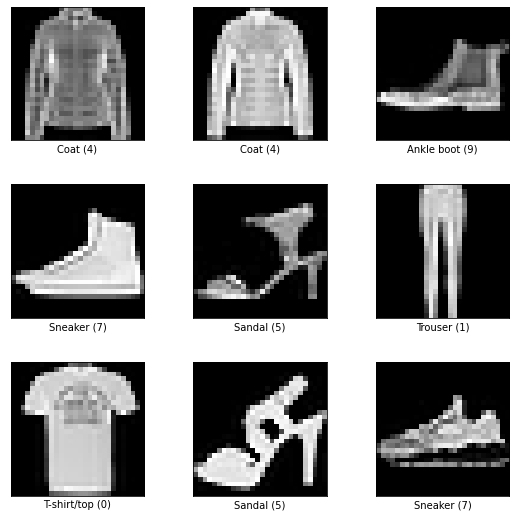

In [48]:
#@title Run to download and prepare dataset
#@markdown - https://www.tensorflow.org/datasets/catalog/fashion_mnist

import tensorflow as tf
import tensorflow_datasets as tfds

(__DS_TRAIN, __DS_TEST), __DS_INFO = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

_ = tfds.show_examples(__DS_TEST, __DS_INFO)

# Prepare splits
def __normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
# Prepare train split
__DS_TRAIN = __DS_TRAIN.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TRAIN = __DS_TRAIN.cache()
__DS_TRAIN = __DS_TRAIN.shuffle(__DS_INFO.splits['train'].num_examples)
__DS_TRAIN = __DS_TRAIN.batch(128)
__DS_TRAIN = __DS_TRAIN.prefetch(tf.data.experimental.AUTOTUNE)
# Prepare test split
__DS_TEST = __DS_TEST.map(__normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
__DS_TEST = __DS_TEST.batch(128)
__DS_TEST = __DS_TEST.cache()
__DS_TEST = __DS_TEST.prefetch(tf.data.experimental.AUTOTUNE)

In [49]:
#@title Run to setup model genome processing code
#@markdown A model genome is a string having `;` seperated parts where each part describes a specific layer.
#@markdown 
#@markdown For eg., this cell genome has 1 normal convolution layer followed by 2 reduction convolution layers and relu activation in the final layer.
#@markdown ```
#@markdown NC 10 2 sigmoid;RC 10 3 relu;RC 10 3 relu;FL relu;
#@markdown ```
#@markdown 
#@markdown In the above example the normal layer has 10 CNN filters having a kernel size of 2 and sigmoid activation. After the normal layer it has 2 reduction layers with 10 filters, kernel size of 3 and relu activation function. This example therefore has 3 internal layers. Finally, the genome specifies `relu` activation for the final layer(FL).
#@markdown 
#@markdown The format for each genome part for `NC` and `RC` layers is as follows,
#@markdown ```
#@markdown <NC or RC> <no. of CNN filters> <kernel size LESS THAN 8> <activation function>;
#@markdown ```
#@markdown After all `NC` and `RC` genome parts the final layer genome part has the following format,
#@markdown ```
#@markdown FL <activation function>;
#@markdown ```
#@markdown With the above, the full genome format is,
#@markdown ```
#@markdown <any number of FC/RC genome parts>;FL <activation function>;
#@markdown ```
#@markdown Here,
#@markdown - `NC` is normal genome and `RC` is reduction genome. Normal genomes keep the dimentions of the input image intact (i.e. `stride=1`), while reduction genomes make the output image dimension half of the input dimension.
#@markdown  - See the constraints section above for specific details.
#@markdown - Every genome **MUST** have **EXACTLY 2** `RC` parts. These `RC` parts can be placed anywhere in the genome.

import tensorflow as tf
import tensorflow_addons as tfa
import re
from collections import Counter

__ALLOWED_ACTIVATIONS = [
                         'relu',
                         'sigmoid',
                         'tanh',
                         'swish',
                         'gelu',
]
__VALIDATION_RE_CELL = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?')
__VALIDATION_RE_FL = re.compile(f'FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')
__VALIDATION_RE = re.compile(f'((?P<type>NC|RC) (?P<filters>\d+?) (?P<kernel>[1234567]) (?P<activation>{"|".join(__ALLOWED_ACTIVATIONS)});)+?FL (?P<fl_activation>{"|".join(__ALLOWED_ACTIVATIONS)});')

__SAMPLE_GENOME = 'NC 1 1 sigmoid;RC 2 3 relu;RC 5 7 relu;'

def parse_genome(cellgenome: str):
  if __VALIDATION_RE.fullmatch(cellgenome) is None:
    raise Exception(f'Invalid genome (parse error): {cellgenome}\n Please check that the genome is in the correct format.')
  parse = __VALIDATION_RE_CELL.findall(cellgenome)
  # check constraints
  type_count = Counter()
  for idx, cell in enumerate(parse):
    type_count.update([cell[1]])
    filter = int(cell[2])
    kernel = int(cell[3])
    if filter < 1:
      raise Exception(f'Invalid filter size {filter} for layer {idx+1}.')
    if kernel < 1 or kernel > 7:
      raise Exception(f'Invalid kernel size {filter} for layer {idx+1}.')
  if type_count['RC'] != 2:
    raise Exception(f'Genome must have exacly 2 RC parts. Your genome has {type_count["RC"]} RC parts.')
  return parse + __VALIDATION_RE_FL.findall(cellgenome)

def genome_to_model(cellgenome: str, lr: float = 2e-3, lr_decay: float = 0.05):
  # parse genome
  parsed = parse_genome(cellgenome)
  def _match_to_layer(match_tuple, idx):
    return tf.keras.layers.Conv2D(
        filters = int(match_tuple[2]),
        kernel_size = int(match_tuple[3]),
        strides = 1 if match_tuple[1] == 'NC' else 2,
        name = f'Layer_{idx}_{match_tuple[1]}',
        activation = match_tuple[4],
        padding = 'same' if match_tuple[1] == 'NC' else 'valid',
    )
  # create model object
  model = tf.keras.Sequential(
    [
      *[_match_to_layer(cell, idx) for idx, cell in enumerate(parsed[:-1])],
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(
          64,
          activation=parsed[-1],
      ),
      tf.keras.layers.Dense(
          __DS_INFO.features['label'].num_classes,
          activation=parsed[-1],
      ),
    ]
  )
  # compile the model
  model.compile(
      optimizer=tfa.optimizers.AdamW(
          learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr,
            decay_steps=len(__DS_TRAIN)*10,
            decay_rate=lr_decay,
          ),
          weight_decay=1e-9,
      ),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )
  model.build((None, *__DS_INFO.features['image'].shape))
  return model

In [50]:
#@title Use this form to validate a genome and see the resulting model
#@markdown Enter your genome in this text field and then run this cell.
__fr_model_genome = "RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;" #@param {type:"string"}

try:
  __fr_model = genome_to_model(__fr_model_genome)
  __fr_model.summary()
  del __fr_model
except Exception as e:
  print(e)
  print()
  print(f'Your input genome: {__fr_model_genome}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_RC (Conv2D)         (None, 13, 13, 10)        100       
                                                                 
 Layer_1_NC (Conv2D)         (None, 13, 13, 20)        1820      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 10)          1810      
                                                                 
 global_average_pooling2d_3   (None, 10)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 64)                704       
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                        

In [51]:
__fr_model_genome = "RC 10 3 tanh;NC 20 3 relu;RC 10 3 swish;FL swish;"

In [52]:
#@title Run to setup model training code
#@markdown You are provided with two functions,
#@markdown - **`get_model_parameters(model_genome: str)`**: This function accepts the model genome string and returns the number of parameters that the model will have. You can use this function to query for the number of parameters without training the model entirely.
#@markdown 
#@markdown    **Returns**: A single integer representing the number of parameters in the model.

#@markdown - **`train_model(model_genome: str, verbose: int = 1, lr: float = None, lr_decacy: float = None)`**: This function accepts the model genome string and trains the model on the Fashion-MNIST dataset. You must use this function to train models based on your genome string.
#@markdown 
#@markdown      - If `verbose` is `0` then this function does not print anything while training
#@markdown      - If `verbose` is `1` then it prints the training progess on each call and the final test accuracy.
#@markdown      - If `verbose` is `2` then it prints everything from `varbose=1` and also prints the model summary (structure).
#@markdown 
#@markdown  It accepts a learning rate (`lr`) and a learning rate exponential decay rate (`lr_decay`). You do not need to provide values for `lr` and `lr_decay`, the default values are tuned to give good performance  3~10 layer networks. Below you will find some example values for a sample shallow network and a sample deep network.
#@markdown 
#@markdown   **Returns**: A tuple of `(test accuracy, train accuracy, number of parameters)`.
#@markdown 
#@markdown Using the above two functions you must create a search method to search for a model genome which gives the maximum **test accuracy**. You are given the train accuracy to identify _overfitting_ if you wish to do so. You can also use the number of parameters to prefer models having fewer parameters and find a good balance between test accuracy and number of parameters.

def get_model_parameters(modelgenome: str):
  '''
  Returns the number of parameters that this genome creates.
  '''
  model = genome_to_model(modelgenome)
  return model.count_params()

def train_model(modelgenome: str, verbose: int = 1, lr: float = None, lr_decay: float = None):
  '''
  Accepts a genome string and trains the corresponding model on Fashion MNIST dataset.
  Thorws exceptions if the provided genome is invalid.
  Returns a tuple: (test accuracy, train accuracy, number of parameters)
  '''
  model = genome_to_model(modelgenome, lr=lr, lr_decay=lr_decay)
  n_params = model.count_params()
  if verbose > 0:
    print(f'Training genome: {modelgenome}')
    print(f'Model params: {n_params}')
  if verbose > 1:
    model.summary()
  # train model
  callbacks = [
    tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      mode='min',
      baseline=10.0,
      patience=2,
      min_delta=0.005,
      verbose=verbose,
    )
  ]
  if verbose > 0:
    callbacks.append(
      tfa.callbacks.TQDMProgressBar(
        update_per_second = 1,
        leave_epoch_progress = verbose > 1,
        leave_overall_progress = verbose > 1,
      )
    )
  ret = model.fit(
      __DS_TRAIN,
      epochs=10,
      verbose=0,
      callbacks=callbacks,
      validation_data=__DS_TEST,
  )
  # delete model
  del model
  # get best history
  best_idx = max(range(len(ret.history['val_accuracy'])), key=ret.history['val_accuracy'].__getitem__)
  best_history = {
      k: v[best_idx] for k, v in ret.history.items()
  }
  if verbose > 0:
    print(f'Best test accuracy: {best_history["val_accuracy"]}')
  return (best_history['val_accuracy'], best_history['accuracy'], n_params)

#### MY Code

In [87]:
dic={
    0:"relu",
    1:"sigmoid",
    2:"tanh",
    3:"swish",
    4:"gelu"
}
c={
    0:{"min":1,"max":100},
    1:{"min":1,"max":7},
    2:{"min":1,"max":4}
    
}
import random
solution=[]
for i in range(10):
  solution.append([random.randint(1,100),random.randint(1,7),random.randint(0,4),
                   random.randint(1,100),random.randint(1,7),random.randint(0,4),
                   random.randint(1,100),random.randint(1,7),random.randint(0,4),
                   random.randint(0,4)
                   
                   ])      




In [88]:
solution


[[17, 7, 1, 48, 6, 1, 37, 5, 1, 4],
 [12, 4, 1, 20, 4, 0, 27, 1, 2, 0],
 [60, 7, 3, 97, 2, 2, 19, 2, 2, 3],
 [19, 6, 4, 31, 6, 1, 4, 4, 3, 0],
 [71, 3, 1, 61, 1, 3, 86, 6, 1, 0],
 [8, 2, 0, 22, 5, 4, 71, 7, 1, 3],
 [60, 1, 2, 18, 3, 0, 53, 2, 0, 4],
 [3, 2, 2, 49, 6, 3, 32, 3, 4, 4],
 [21, 3, 2, 88, 5, 1, 23, 1, 0, 3],
 [84, 1, 2, 94, 1, 1, 78, 4, 4, 2]]

In [89]:
# i=1
# c[i]["min"],i["max"]

In [90]:
p=random_solution(3,c,5)

In [91]:
ste_str=["NC","RC","RC","FL"]
def para_to_string(para):
  st=[]
  
  for i in para:
    count=0
    #ste=""
    ste="NC "+str(i[0])+" "+str(i[1])+" "+dic[i[2]]+";"+"RC "+str(i[3])+" "+str(i[4])+" "+dic[i[5]]+";"+"RC "+str(i[6])+" "+str(i[7])+" "+dic[i[8]]+";"+"FL " + dic[i[9]]+";"
    st.append(ste)
  return st


  #     ste

para_to_string(solution)

['NC 17 7 sigmoid;RC 48 6 sigmoid;RC 37 5 sigmoid;FL gelu;',
 'NC 12 4 sigmoid;RC 20 4 relu;RC 27 1 tanh;FL relu;',
 'NC 60 7 swish;RC 97 2 tanh;RC 19 2 tanh;FL swish;',
 'NC 19 6 gelu;RC 31 6 sigmoid;RC 4 4 swish;FL relu;',
 'NC 71 3 sigmoid;RC 61 1 swish;RC 86 6 sigmoid;FL relu;',
 'NC 8 2 relu;RC 22 5 gelu;RC 71 7 sigmoid;FL swish;',
 'NC 60 1 tanh;RC 18 3 relu;RC 53 2 relu;FL gelu;',
 'NC 3 2 tanh;RC 49 6 swish;RC 32 3 gelu;FL gelu;',
 'NC 21 3 tanh;RC 88 5 sigmoid;RC 23 1 relu;FL swish;',
 'NC 84 1 tanh;RC 94 1 sigmoid;RC 78 4 gelu;FL tanh;']

In [92]:
s_solution=para_to_string(solution)
ranks=[]
# for i in s_solution:

#   a,b,c=train_model(i, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay)
#   ranks.append([a,i])
#   #print(s)
#   #input()
for i in range(3):
  ranks=[]
  for i in s_solution:
    a,b,c=train_model(i, verbose=2, lr=__fr_lr, lr_decay=__fr_lr_decay)
    ranks.append([a,i])
  ranks.sort()
  ranks.reverse()
  best=ranks[:int(len(ranks)/2)]
  elements=[]
  for j in best:
    elements.append(j[1])

  temo=[]
  for i in range(len(ranks)-int(len(ranks)/2)):
    temo.append([random.randint(1,100),random.randint(1,7),random.randint(0,4),
                    random.randint(1,100),random.randint(1,7),random.randint(0,4),
                    random.randint(1,100),random.randint(1,7),random.randint(0,4),
                    random.randint(0,4)
                    
                    ])  
  elements=elements+para_to_string(temo)
  s_solution=elements


s_solution[0]
  
  





Training genome: NC 17 7 sigmoid;RC 48 6 sigmoid;RC 37 5 sigmoid;FL gelu;
Model params: 77793
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 17)        850       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 48)        29424     
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 37)          44437     
                                                                 
 global_average_pooling2d_44  (None, 37)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_85 (Dense)            (None, 64)                2432      
                                                                 
 dense_86 (Dense)        

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.78329998254776
Training genome: NC 12 4 sigmoid;RC 20 4 relu;RC 27 1 tanh;FL relu;
Model params: 7073
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 12)        204       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 20)        3860      
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 27)          567       
                                                                 
 global_average_pooling2d_45  (None, 27)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_87 (Dense)            (None, 64)                1792      
                                                             

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.25380000472068787
Training genome: NC 60 7 swish;RC 97 2 tanh;RC 19 2 tanh;FL swish;
Model params: 35698
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 60)        3000      
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 97)        23377     
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 19)          7391      
                                                                 
 global_average_pooling2d_46  (None, 19)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_89 (Dense)            (None, 64)                1280      
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7871999740600586
Training genome: NC 19 6 gelu;RC 31 6 sigmoid;RC 4 4 swish;FL relu;
Model params: 24896
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 19)        703       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 31)        21235     
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 4)           1988      
                                                                 
 global_average_pooling2d_47  (None, 4)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_91 (Dense)            (None, 64)                320       
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.5976999998092651
Training genome: NC 71 3 sigmoid;RC 61 1 swish;RC 86 6 sigmoid;FL relu;
Model params: 200262
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 71)        710       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 61)        4392      
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 86)          188942    
                                                                 
 global_average_pooling2d_48  (None, 86)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_93 (Dense)            (None, 64)                5568      
                                                     

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 00003: early stopping
Best test accuracy: 0.10000000149011612
Training genome: NC 8 2 relu;RC 22 5 gelu;RC 71 7 sigmoid;FL swish;
Model params: 86329
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         40        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 22)        4422      
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 71)          76609     
                                                                 
 global_average_pooling2d_49  (None, 71)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_95 (Dense)            (None, 64)                4608      
                             

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8562999963760376
Training genome: NC 60 1 tanh;RC 18 3 relu;RC 53 2 relu;FL gelu;
Model params: 17833
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 60)        120       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 18)        9738      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 53)          3869      
                                                                 
 global_average_pooling2d_50  (None, 53)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_97 (Dense)            (None, 64)                3456      
                                                             

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7547000050544739
Training genome: NC 3 2 tanh;RC 49 6 swish;RC 32 3 gelu;FL gelu;
Model params: 22262
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 3)         15        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 49)        5341      
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 32)          14144     
                                                                 
 global_average_pooling2d_51  (None, 32)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_99 (Dense)            (None, 64)                2112      
                                                             

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8138999938964844
Training genome: NC 21 3 tanh;RC 88 5 sigmoid;RC 23 1 relu;FL swish;
Model params: 50731
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 21)        210       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 88)        46288     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 23)          2047      
                                                                 
 global_average_pooling2d_52  (None, 23)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_101 (Dense)           (None, 64)                1536      
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7565000057220459
Training genome: NC 84 1 tanh;RC 94 1 sigmoid;RC 78 4 gelu;FL tanh;
Model params: 131254
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 84)        168       
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 94)        7990      
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 78)          117390    
                                                                 
 global_average_pooling2d_53  (None, 78)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_103 (Dense)           (None, 64)                5056      
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.754800021648407
Training genome: NC 8 2 relu;RC 22 5 gelu;RC 71 7 sigmoid;FL swish;
Model params: 86329
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         40        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 22)        4422      
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 71)          76609     
                                                                 
 global_average_pooling2d_54  (None, 71)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_105 (Dense)           (None, 64)                4608      
                                                           

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.8550000190734863
Training genome: NC 3 2 tanh;RC 49 6 swish;RC 32 3 gelu;FL gelu;
Model params: 22262
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 3)         15        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 49)        5341      
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 32)          14144     
                                                                 
 global_average_pooling2d_55  (None, 32)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_107 (Dense)           (None, 64)                2112      
                                 

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Epoch 00010: early stopping
Best test accuracy: 0.8227999806404114
Training genome: NC 60 7 swish;RC 97 2 tanh;RC 19 2 tanh;FL swish;
Model params: 35698
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 60)        3000      
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 97)        23377     
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 19)          7391      
                                                                 
 global_average_pooling2d_56  (None, 19)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_109 (Dense)           (None, 64)                1280      
                               

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7965999841690063
Training genome: NC 17 7 sigmoid;RC 48 6 sigmoid;RC 37 5 sigmoid;FL gelu;
Model params: 77793
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 17)        850       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 48)        29424     
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 37)          44437     
                                                                 
 global_average_pooling2d_57  (None, 37)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_111 (Dense)           (None, 64)                2432      
                                                    

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7878999710083008
Training genome: NC 21 3 tanh;RC 88 5 sigmoid;RC 23 1 relu;FL swish;
Model params: 50731
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 21)        210       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 88)        46288     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 23)          2047      
                                                                 
 global_average_pooling2d_58  (None, 23)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_113 (Dense)           (None, 64)                1536      
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7663000226020813
Training genome: NC 93 4 sigmoid;RC 70 3 swish;RC 41 5 gelu;FL sigmoid;
Model params: 135370
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 93)        1581      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 70)        58660     
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 41)          71791     
                                                                 
 global_average_pooling2d_59  (None, 41)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_115 (Dense)           (None, 64)                2688      
                                                     

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7778000235557556
Training genome: NC 43 6 gelu;RC 26 3 relu;RC 1 1 sigmoid;FL gelu;
Model params: 12484
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 43)        1591      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 26)        10088     
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 1)           27        
                                                                 
 global_average_pooling2d_60  (None, 1)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_117 (Dense)           (None, 64)                128       
                                                           

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.4228000044822693
Training genome: NC 61 6 relu;RC 46 4 sigmoid;RC 15 6 relu;FL sigmoid;
Model params: 73728
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 61)        2257      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 46)        44942     
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 15)          24855     
                                                                 
 global_average_pooling2d_61  (None, 15)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_119 (Dense)           (None, 64)                1024      
                                                       

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7919999957084656
Training genome: NC 95 6 swish;RC 81 3 swish;RC 88 1 gelu;FL sigmoid;
Model params: 86413
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 95)        3515      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 81)        69336     
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 88)          7216      
                                                                 
 global_average_pooling2d_62  (None, 88)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_121 (Dense)           (None, 64)                5696      
                                                        

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7749999761581421
Training genome: NC 52 6 swish;RC 28 7 swish;RC 2 1 relu;FL gelu;
Model params: 74196
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 52)        1924      
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 28)        71372     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 2)           58        
                                                                 
 global_average_pooling2d_63  (None, 2)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_123 (Dense)           (None, 64)                192       
                                                            

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.6809999942779541
Training genome: NC 8 2 relu;RC 22 5 gelu;RC 71 7 sigmoid;FL swish;
Model params: 86329
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 8)         40        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 22)        4422      
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 71)          76609     
                                                                 
 global_average_pooling2d_64  (None, 71)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_125 (Dense)           (None, 64)                4608      
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8629999756813049
Training genome: NC 3 2 tanh;RC 49 6 swish;RC 32 3 gelu;FL gelu;
Model params: 22262
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 3)         15        
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 49)        5341      
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 32)          14144     
                                                                 
 global_average_pooling2d_65  (None, 32)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_127 (Dense)           (None, 64)                2112      
                                                             

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.8238000273704529
Training genome: NC 60 7 swish;RC 97 2 tanh;RC 19 2 tanh;FL swish;
Model params: 35698
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 60)        3000      
                                                                 
 Layer_1_RC (Conv2D)         (None, 14, 14, 97)        23377     
                                                                 
 Layer_2_RC (Conv2D)         (None, 7, 7, 19)          7391      
                                                                 
 global_average_pooling2d_66  (None, 19)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_129 (Dense)           (None, 64)                1280      
                                                           

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7908999919891357
Training genome: NC 61 6 relu;RC 46 4 sigmoid;RC 15 6 relu;FL sigmoid;
Model params: 73728
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 61)        2257      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 46)        44942     
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 15)          24855     
                                                                 
 global_average_pooling2d_67  (None, 15)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_131 (Dense)           (None, 64)                1024      
                                                       

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7907000184059143
Training genome: NC 17 7 sigmoid;RC 48 6 sigmoid;RC 37 5 sigmoid;FL gelu;
Model params: 77793
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 17)        850       
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 48)        29424     
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 37)          44437     
                                                                 
 global_average_pooling2d_68  (None, 37)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_133 (Dense)           (None, 64)                2432      
                                                    

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7904999852180481
Training genome: NC 63 4 swish;RC 7 6 swish;RC 66 3 swish;FL tanh;
Model params: 26116
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 63)        1071      
                                                                 
 Layer_1_RC (Conv2D)         (None, 12, 12, 7)         15883     
                                                                 
 Layer_2_RC (Conv2D)         (None, 5, 5, 66)          4224      
                                                                 
 global_average_pooling2d_69  (None, 66)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_135 (Dense)           (None, 64)                4288      
                                                           

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7864000201225281
Training genome: NC 81 3 tanh;RC 39 7 swish;RC 82 6 relu;FL swish;
Model params: 276812
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 81)        810       
                                                                 
 Layer_1_RC (Conv2D)         (None, 11, 11, 39)        154830    
                                                                 
 Layer_2_RC (Conv2D)         (None, 3, 3, 82)          115210    
                                                                 
 global_average_pooling2d_70  (None, 82)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_137 (Dense)           (None, 64)                5312      
                                                          

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 00009: early stopping
Best test accuracy: 0.8885999917984009
Training genome: NC 30 5 relu;RC 3 4 sigmoid;RC 23 6 sigmoid;FL swish;
Model params: 6916
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 30)        780       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 3)         1443      
                                                                 
 Layer_2_RC (Conv2D)         (None, 4, 4, 23)          2507      
                                                                 
 global_average_pooling2d_71  (None, 23)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_139 (Dense)           (None, 64)                1536      
                            

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7330999970436096
Training genome: NC 65 5 gelu;RC 100 3 sigmoid;RC 28 2 tanh;FL relu;
Model params: 74024
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 65)        1690      
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 100)       58600     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 28)          11228     
                                                                 
 global_average_pooling2d_72  (None, 28)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_141 (Dense)           (None, 64)                1856      
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.46000000834465027
Training genome: NC 58 2 tanh;RC 32 4 relu;RC 54 3 sigmoid;FL relu;
Model params: 49794
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_0_NC (Conv2D)         (None, 28, 28, 58)        290       
                                                                 
 Layer_1_RC (Conv2D)         (None, 13, 13, 32)        29728     
                                                                 
 Layer_2_RC (Conv2D)         (None, 6, 6, 54)          15606     
                                                                 
 global_average_pooling2d_73  (None, 54)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_143 (Dense)           (None, 64)                3520      
                                                         

Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10


0/469           ETA: ?s - 

Epoch 2/10


0/469           ETA: ?s - 

Epoch 3/10


0/469           ETA: ?s - 

Epoch 4/10


0/469           ETA: ?s - 

Epoch 5/10


0/469           ETA: ?s - 

Epoch 6/10


0/469           ETA: ?s - 

Epoch 7/10


0/469           ETA: ?s - 

Epoch 8/10


0/469           ETA: ?s - 

Epoch 9/10


0/469           ETA: ?s - 

Epoch 10/10


0/469           ETA: ?s - 

Best test accuracy: 0.7009999752044678


'NC 81 3 tanh;RC 39 7 swish;RC 82 6 relu;FL swish;'

#### End my code


## Hints

- Consider caching genome results for faster querying.
  - This has a risk. The training process itself is non-deterministic and thus training the same genome multiple times can sometimes give drastically different results. Generally such difference in accuracy of the same genome is small but sometimes it be upto 30%.
- Consider saving your search algorithm state such that it can resume from a previous search point if it gets interrupted due to a crash or colab time restrictions.
  - Google colab is free and hence it has time limits on how long you can use the GPU. If you implement checkpointing in your code such that it saves checkpoints on your GDrive, you can save a lot of time when such interruptions happen.
  - You can mount your GDrive to colab and save/load files from your drive folders.
- Don't forget to enable GPU in colab.
  - https://colab.research.google.com/notebooks/gpu.ipynb
- If colab shows errors in code that was working before try to do `Runtime->Restart Runtime`. This is especially true if you stopped execution while a model was being trained.
  - You can also try `Runtime->Factory Reset Runtime` to get a clean slate (revert installed libraries to colab defaults).